## Setup

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

## Load data and introduce non-linearity

Our electromagnet model provides linear relationship between the voltage and field. In order to explore non-linear relationship, we need to introduce non-linearity by hand. We will do it  by applying tanh element-wise to the field values.

In [26]:
#Training data
df = pd.read_csv('data/individual_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

# Introduce non-linearity
nf = 15 # Non-linearity factor
Bx, By, Bz = np.tanh(Bx/nf)*np.max(Bx), np.tanh(By/nf)*np.max(By), np.tanh(Bz/nf)*np.max(Bz)

# Stack data for the network
B_train = np.stack((Bx, By, Bz), axis=1)
V_train = np.stack((V1, V2, V3), axis=1)

In [29]:
#Validation data
df_val = pd.read_csv('data/validation_set.csv')

Bx_val, By_val, Bz_val = df_val['B_x'].to_numpy(), df_val['B_y'].to_numpy(), df_val['B_z'].to_numpy() # Extract fields
V1_val, V2_val, V3_val = df_val['V_1'].to_numpy(), df_val['V_2'].to_numpy(), df_val['V_3'].to_numpy()  # Extract voltages

# Introduce non-linearity
nf = 15 # Non-linearity factor
Bx_val, By_val, Bz_val = np.tanh(Bx_val/nf)*np.max(Bx_val), np.tanh(By_val/nf)*np.max(By_val), np.tanh(Bz_val/nf)*np.max(Bz_val)

# Stack data for the network
B_val = np.stack((Bx_val, By_val, Bz_val), axis=1)
V_val = np.stack((V1_val, V2_val, V3_val), axis=1)

## Plot non-linear data

In [7]:
def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)
    ax.set_xlabel(r'$V_1$ (arb. u.)')
    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

<AxesSubplot:xlabel='$V_1$ (arb. u.)', ylabel='Field (arb. u.)'>

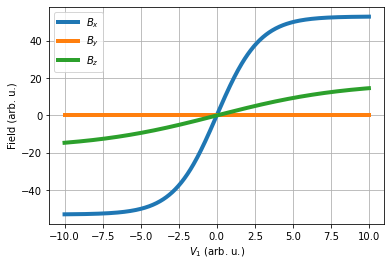

In [8]:
B_vs_V(V1, Bx, By, Bz)

Text(0.5, 0, '$V_2$ (arb. u.)')

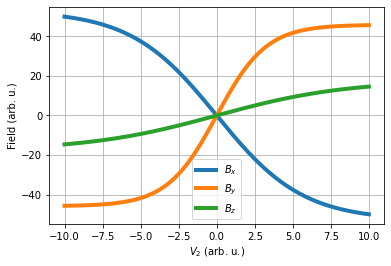

In [9]:
ax2 = B_vs_V(V2, Bx, By, Bz)
ax2.set_xlabel(r'$V_2$ (arb. u.)')

Text(0.5, 0, '$V_3$ (arb. u.)')

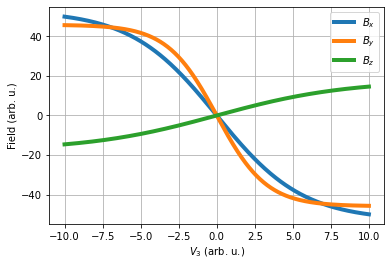

In [10]:
ax3 = B_vs_V(V3, Bx, By, Bz)
ax3.set_xlabel(r'$V_3$ (arb. u.)')

## 'Deep' learning

In [11]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.Dense(3),
    keras.layers.Dense(18,activation='relu'),
    keras.layers.Dense(3)
])

In [12]:
# Compile model
model.compile(loss="mse", optimizer = keras.optimizers.Adam(), metrics=["mae"])

In [13]:
# Add a callback that stops training if mean absolute error does not improve for 300 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=300, monitor='val_mae',restore_best_weights=True)

In [ ]:
# Train model
history = model.fit(B_train, Y_train, epochs=1000, validation_data=(B_test, Y_test),batch_size=8,callbacks=[checkpoint_cb,early_stopping_cb])